In [ ]:
!pip install timm

In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection, pipeline
import torch
from PIL import Image
import requests

url = "https://img.freepik.com/premium-photo/group-happy-playful-indian-children-running-outdoors-park-asian-kids-playing-garden_979520-4964.jpg"
#url = "https://i.pinimg.com/originals/8e/51/a4/8e51a4c0fd038e5522a3d1dc7890a45d.jpg"
#url = "https://wwf.ca/wp-content/uploads/2020/03/Arctic-shipping-c-iStock-e1585925976736.jpg"
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#url = "https://pe-images.s3.amazonaws.com/basics/cc/image-size-resolution/resize-images-for-print/image-cropped-8x10.jpg"
#url = "https://www.devoteam.com/wp-content/uploads/2021/04/2019-07-02-8.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
pipe = pipeline("object-detection", model="facebook/detr-resnet-50")

Detected person with confidence 0.999 at location [422.05, 133.85, 549.63, 424.79]
Detected person with confidence 0.999 at location [189.51, 100.49, 321.84, 458.2]
Detected backpack with confidence 0.983 at location [211.71, 165.78, 284.8, 237.81]
Detected person with confidence 0.999 at location [79.38, 113.51, 190.0, 375.02]
Detected person with confidence 0.999 at location [311.6, 128.27, 445.89, 441.44]


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

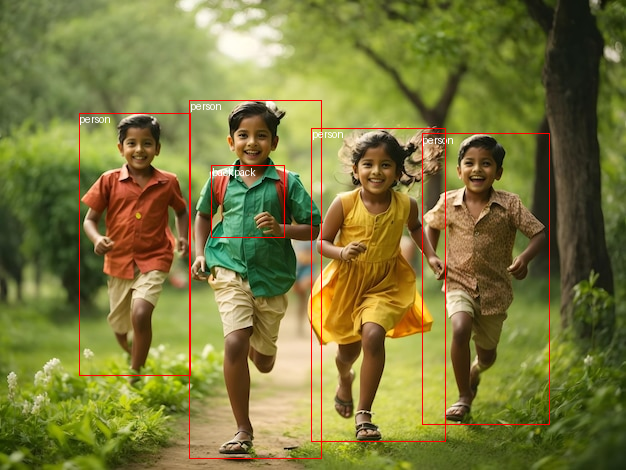

In [2]:
from PIL import Image, ImageDraw
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):

    box = [round(i, 2) for i in box.tolist()]

    x, y, x2, y2 = tuple(box)

    draw.rectangle((x, y, x2, y2), outline="red", width=1)

    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image